# AI 4 StoryLines - Bayesian LR

In this example, we are going to showcase how we can do sensitivity analysis using a simple linear regression model.

In [33]:
import autoroot
import numpy as np
from numpyro.infer import MCMC, NUTS
import arviz as az
from pathlib import Path
from dataclasses import dataclass
import xarray as xr
import pandas as pd
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from bayesevt._src.utils.io import get_list_filenames
from utils import plot_contour, plot_imshow, plot_pcolormesh, interpolate_rectilinear_grid


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We can see that there is some explained variance that is missing.
Potentially we can explain this with the regression model.

### Load Data

We have a clean analysis-ready dataset available from the previous notebook.
We will save it and revisit it later.

First, we will make sure that the models in the covariates and the QoI are the same.

In [35]:
results_save_dir = "/pool/usuarios/juanjohn/data/ai4storylines/results/"

## Metrics

#### Log-Likelihood

$$
\mathcal{L} := \frac{1}{N}\sum_{m=1}^M \log p(\mathbf{u}_{m}|\boldsymbol{\theta})
$$

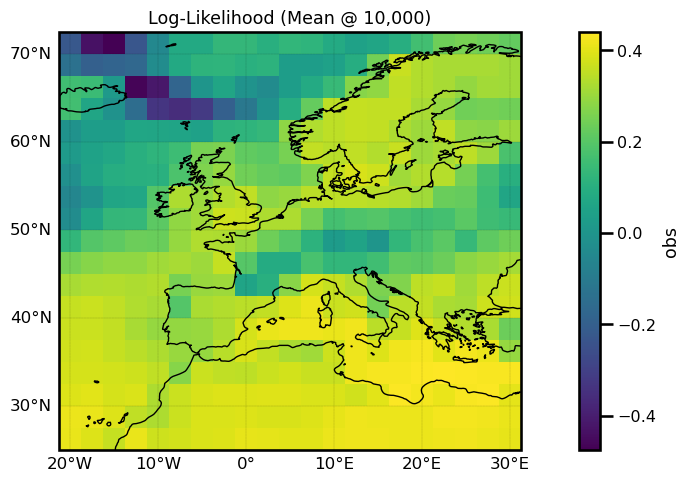

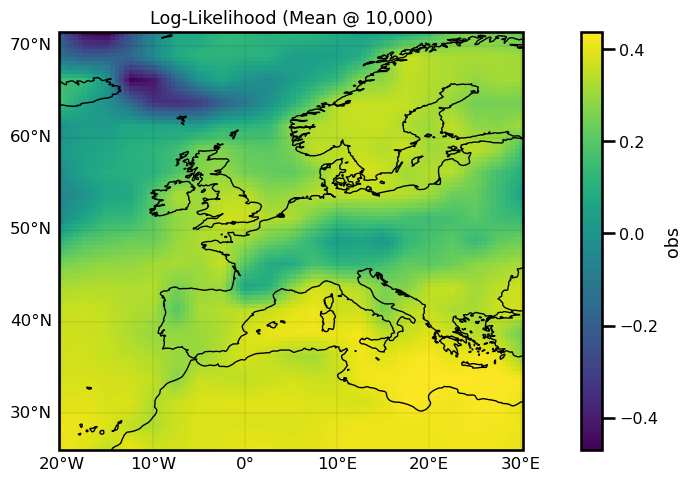

In [36]:
with xr.open_dataset(Path(results_save_dir).joinpath("bhm_mcmc_norm.nc"), group="log_likelihood") as ds:
    
    # extract subsample
    ds = az.extract(ds, num_samples=10_000)

    # subset variable
    ds = ds.obs

    # calculate the mean
    ds = ds.median(["sample", "model"])

    # plot weights
    plot_pcolormesh(
        ds, 
        variable="Log-Likelihood (Mean @ 10,000)", 
        vmin=ds.min().values, vmax=ds.max().values, cmap="viridis"
    );

    
    ds = interpolate_rectilinear_grid(ds, 100, "linear")

    # plot weights
    plot_imshow(
        ds, 
        variable="Log-Likelihood (Mean @ 10,000)", 
        vmin=ds.min().values, vmax=ds.max().values, cmap="viridis", num_levels=None
    );

    ds.close()


#### R2 Score

This is the coefficient of determination.


**Definition**: *the proportion of the variation in the dependent variable that is predictible from the independent variable(s)*.

In other words, it is a score that shows how well the model predicts the outcome of the depenedent variable.

$$
\text{R-Squared} = 1 - \frac{\text{Total Variance Explained by the Model}}{\text{Total Variance}}
$$

Essentially, if it is 100%, there is no variance as the two variables are perfectly correlated.

***

**Equation**

$$
\begin{aligned}
\text{Mean of Observed Data}: && &&
\bar{\mathbf{u}} &= \frac{1}{M}\sum_{m=1}^M \mathbf{u}_m ,
&& && \bar{\mathbf{u}}\in\mathbb{R}^{D_\Omega} \\
\text{Residual Sum of Squares}: && &&
SS_{res} &= \sum_{m=1}^M (\mathbf{u}_m - \boldsymbol{f}_m)^2 ,
&& && SS_{res}\in\mathbb{R}^{D_\Omega} \\
\text{Total Squares}: && &&
SS_{tot} &= \sum_{m=1}^M (\mathbf{u}_m - \bar{\mathbf{u}})^2 ,
&& && SS_{res}\in\mathbb{R}^{D_\Omega} \\
\text{R-Squared}: && &&
\text{R}^2 &= 1 - \frac{SS_{res}}{SS_{tot} } ,
&& && \text{R}^2\in\mathbb{R}^{D_\Omega} \\
\end{aligned}
$$

In [37]:
from sklearn.metrics import r2_score

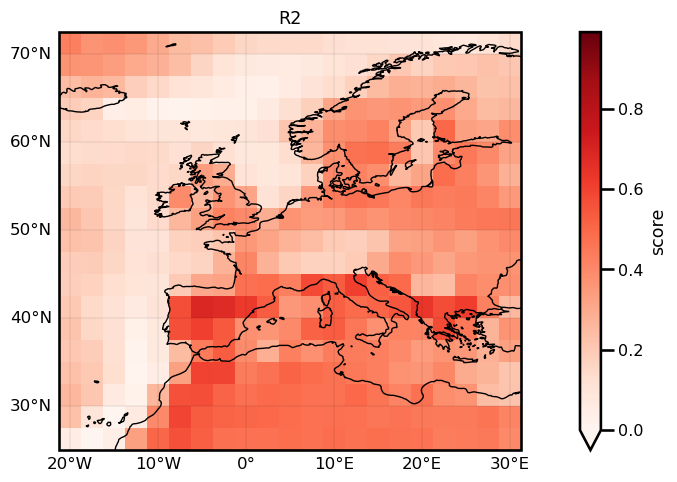

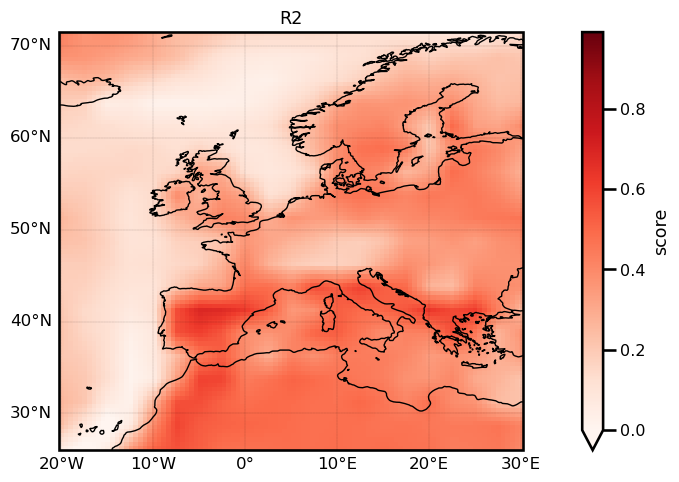

In [38]:
with xr.open_dataset(Path(results_save_dir).joinpath("bhm_mcmc_norm.nc"), group="observed_data") as ds_obs:
    with xr.open_dataset(Path(results_save_dir).joinpath("bhm_mcmc_norm.nc"), group="predictions") as ds_pred:
    
        # extract subsample of predictions
        ds_pred = az.extract(ds_pred, num_samples=1_000)

        # stack spatial coords to make samples
        ds_obs = ds_obs.stack(spatial=["lat", "lon"])
        ds_pred = ds_pred.stack(spatial=["lat", "lon"])

        # get mean predictions across samples
        ds_pred = ds_pred.pred.mean(["sample"])

        # calculate R2 Score
        score = r2_score(y_true=ds_obs.obs.values, y_pred=ds_pred.values, multioutput="raw_values")

        # store results in predictions
        ds_obs["score"] = (("spatial"), score)

        # unstack grid (lat-lon)
        ds_obs = ds_obs.score.unstack()
        plot_pcolormesh(
            ds_obs.unstack(), 
            "R2", vmin=0.0, vmax=0.99, cmap="Reds",
        );
        
        # interpolate
        ds_obs = ds_obs.interp(
                lon=np.linspace(ds_obs.lon.values.min(), ds_obs.lon.values.max(), 100),
                lat=np.linspace(ds_obs.lat.values.min(), ds_obs.lat.values.max(), 100),
                method="linear"
                
            )
    
        plot_imshow(
            ds_obs.unstack(), 
            "R2", vmin=0.0, vmax=0.99, cmap="Reds", num_levels=None
        );
        
        ds_obs.close()
        ds_pred.close()

### Bias Parameter

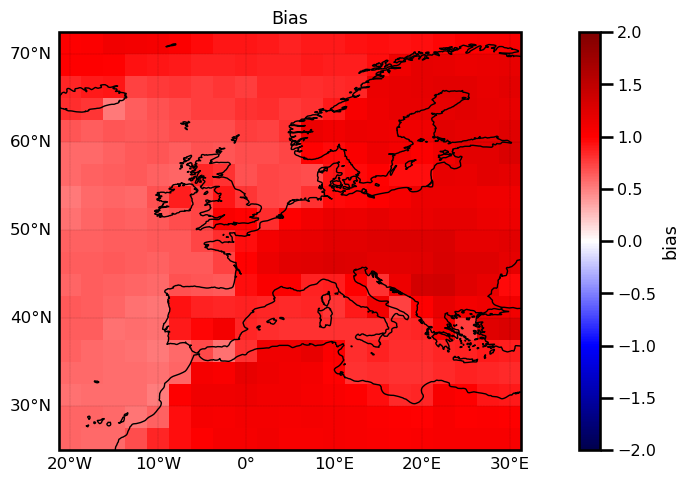

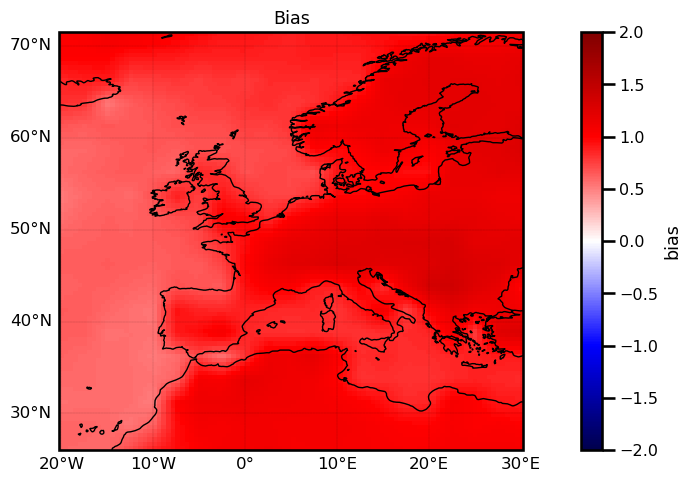

In [39]:
with xr.open_dataset(Path(results_save_dir).joinpath("bhm_mcmc_norm.nc"), group="posterior") as ds:
    
    # extract subsample
    ds = az.extract(ds, num_samples=10_000)

    # extract variable
    bias = ds.bias

    # calculate the mean
    bias = bias.median(["sample"])

    # unstack grid (D) -> (lat-lon)
    bias = bias.unstack()

    # plot weights
    plot_pcolormesh(
        bias,
        variable="Bias", 
        vmin=-2.0, vmax=2.0, cmap="seismic"
    );

    # interpolate
    bias = bias.interp(
        lon=np.linspace(bias.lon.values.min(), bias.lon.values.max(), 100),
        lat=np.linspace(bias.lat.values.min(), bias.lat.values.max(), 100),
        method="linear"
        
    )

    plot_imshow(
        bias, 
        "Bias", vmin=-2.0, vmax=2.0, cmap="seismic", num_levels=None
    );
    ds.close()

### Noise Parameter

['bias', 'bias_prior_mean', 'bias_prior_scale', 'loc_prior_mean', 'loc_prior_scale', 'scale', 'weight', 'z_scale', 'z_scale_mean', 'z_scale_scale']


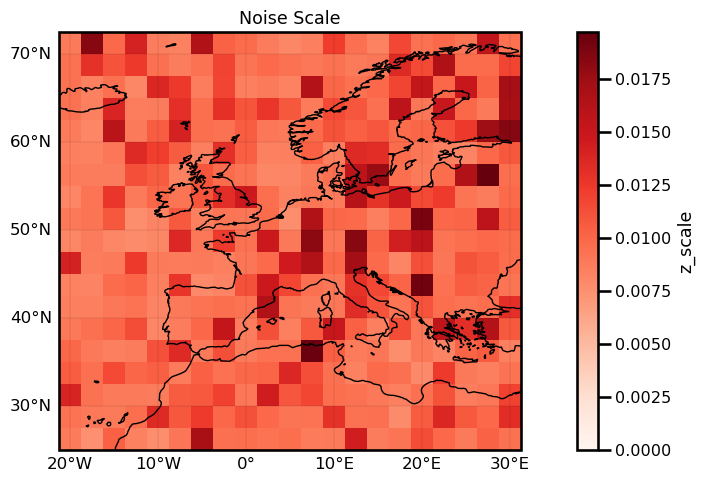

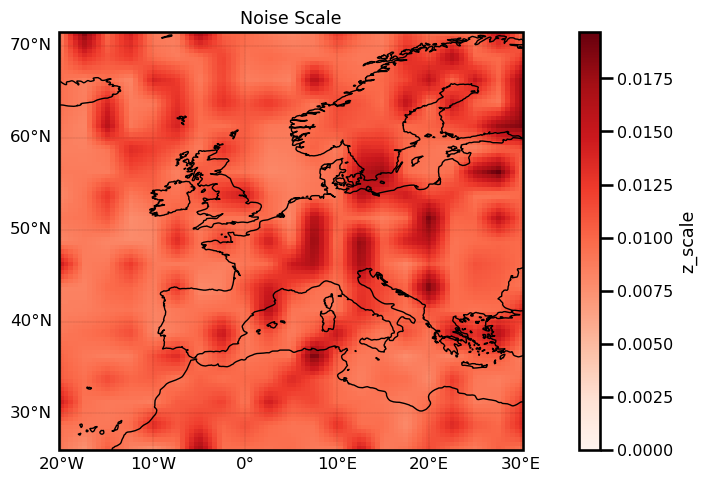

In [40]:
with xr.open_dataset(Path(results_save_dir).joinpath("bhm_mcmc_norm.nc"), group="posterior") as ds:
    
    # extract subsample
    ds = az.extract(ds, num_samples=10_000)

    print(list(ds.keys()))

    # extract variable
    z_scale = ds.z_scale

    # calculate the mean
    z_scale = z_scale.median(["sample"])

    # unstack grid (D) -> (lat-lon)
    z_scale = z_scale.unstack()

    # plot weights
    plot_pcolormesh(
        z_scale,
        variable="Noise Scale", 
        vmin=0.0, vmax=z_scale.max().values, cmap="Reds"
    );

    # interpolate
    z_scale = z_scale.interp(
        lon=np.linspace(z_scale.lon.values.min(), z_scale.lon.values.max(), 100),
        lat=np.linspace(z_scale.lat.values.min(), z_scale.lat.values.max(), 100),
        method="linear"
        
    )

    plot_imshow(
        z_scale, 
        "Noise Scale", vmin=0.0, vmax=z_scale.max().values, cmap="Reds", num_levels=None
    );
    
    ds.close()

## Sensitivity Analysis

In [50]:
def plot_mean_maps(covariate, variable_name):
    with xr.open_dataset(Path(results_save_dir).joinpath("bhm_mcmc_norm.nc"), group="predictions") as ds:
        
        # extract subsample
        ds = az.extract(ds, num_samples=10_000)
    
        # select the variable in dataset
        ds = ds.grads
    
        # select the covariate
        ds = ds.sel(covariate=covariate)
    
        # calculate the mean
        ds = ds.mean(["sample", "model"])
    
        plot_pcolormesh(
            ds,
            variable=f"{variable_name} (Mean)", 
            vmin=-1.0, vmax=1.0, cmap="seismic"
        );
    
        # interpolate
        ds = ds.interp(
            lon=np.linspace(ds.lon.values.min(), ds.lon.values.max(), 100),
            lat=np.linspace(ds.lat.values.min(), ds.lat.values.max(), 100),
            method="linear"
            
        )
        plot_imshow(
            ds,
            variable=f"{variable_name} (Mean)", 
            vmin=-1.0, vmax=1.0, cmap="seismic", num_levels=None
        );

        print(ds.min().values, ds.max().values)
        ds.close()

    

### Sea Surface Temperature

#### Mean & Standard Deviation

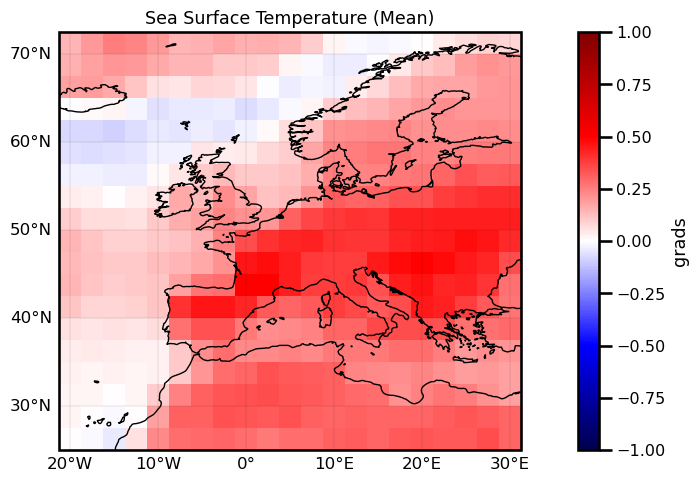

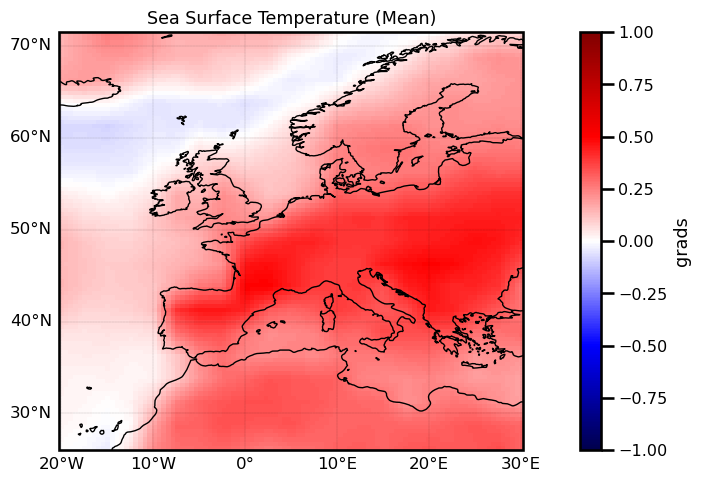

-0.08617945835746899 0.49934652146666947


In [53]:
variable_name = "Sea Surface Temperature"
covariate = "sst_norm"
plot_mean_maps(covariate, variable_name)

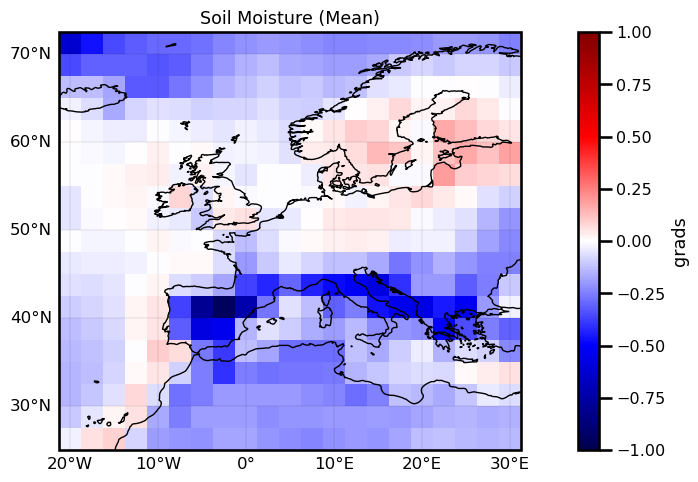

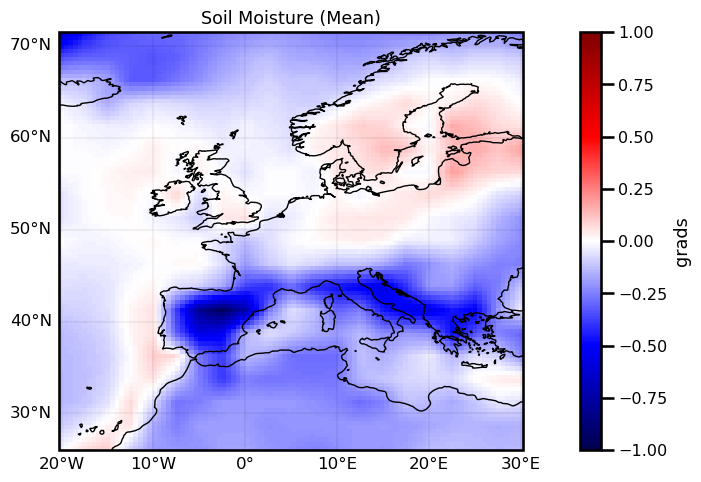

-0.9357145777856459 0.1872543622316289


In [55]:
variable_name = "Soil Moisture"
covariate = "sm_norm"
plot_mean_maps(covariate, variable_name)

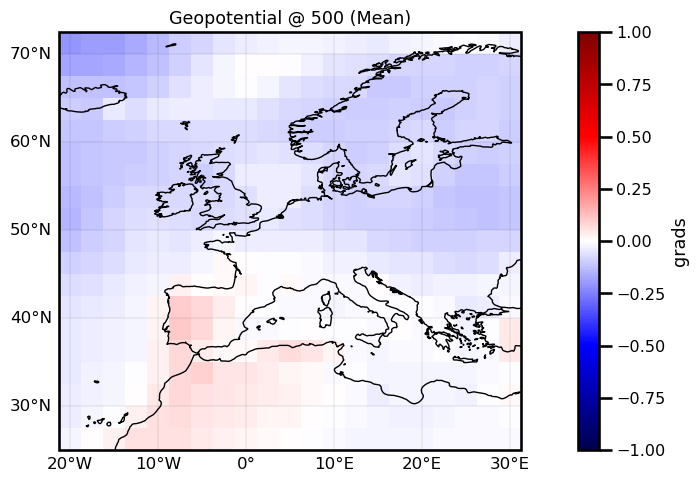

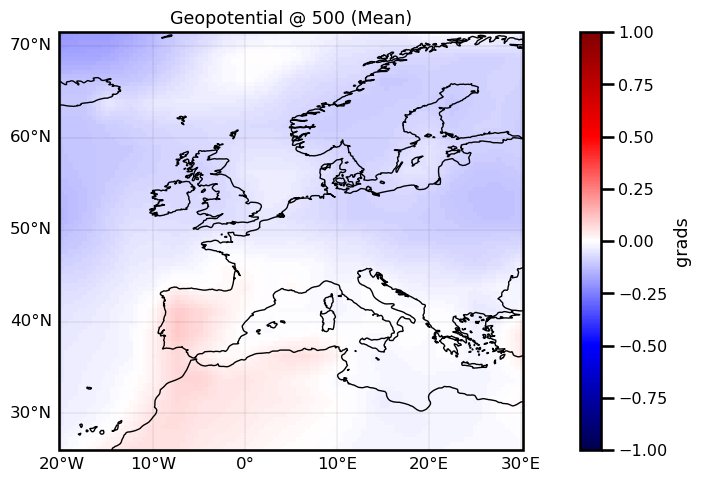

-0.20591993629932404 0.10526196895333141


In [52]:
variable_name = "Geopotential @ 500"
covariate = "z500_norm"
plot_mean_maps(covariate, variable_name)

#### Standard Deviation

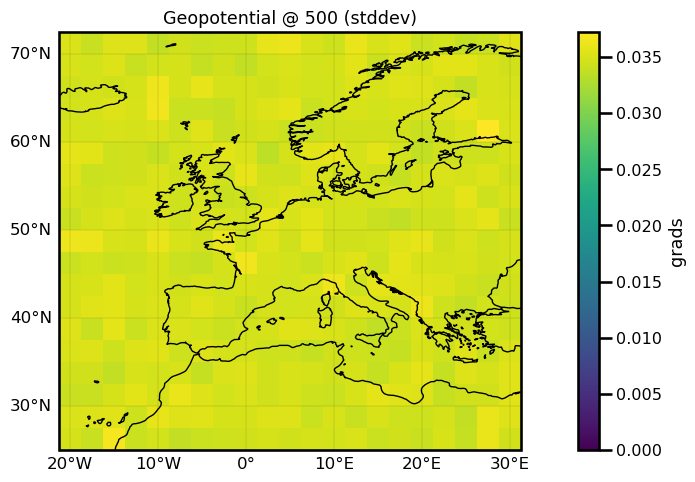

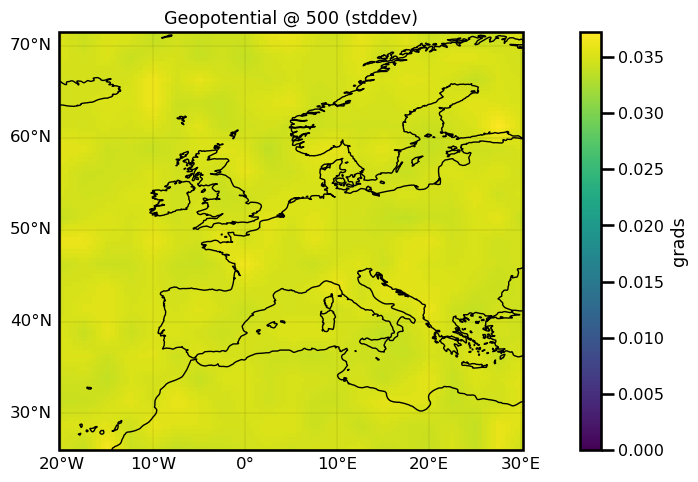

In [19]:
with xr.open_dataset(Path(results_save_dir).joinpath("bhm_mcmc_norm.nc"), group="predictions") as ds:
    
    # extract subsample
    ds = az.extract(ds, num_samples=10_000)

    # select the variable in dataset
    ds = ds.grads

    # select the covariate
    ds = ds.sel(covariate=covariate)

    # calculate the standard deviation
    ds = ds.std(["sample", "model"])

    plot_pcolormesh(
        ds,
        variable=f"{variable_name} (stddev)", 
        vmin=0.0, vmax=ds.max().values, cmap="viridis"
    );

    # interpolate
    ds = ds.interp(
        lon=np.linspace(ds.lon.values.min(), ds.lon.values.max(), 100),
        lat=np.linspace(ds.lat.values.min(), ds.lat.values.max(), 100),
        method="linear"
        
    )
    plot_imshow(
        ds,
        variable=f"{variable_name} (stddev)", 
        vmin=0.0, vmax=ds.max().values, cmap="viridis", num_levels=None
    );

#### Quantiles

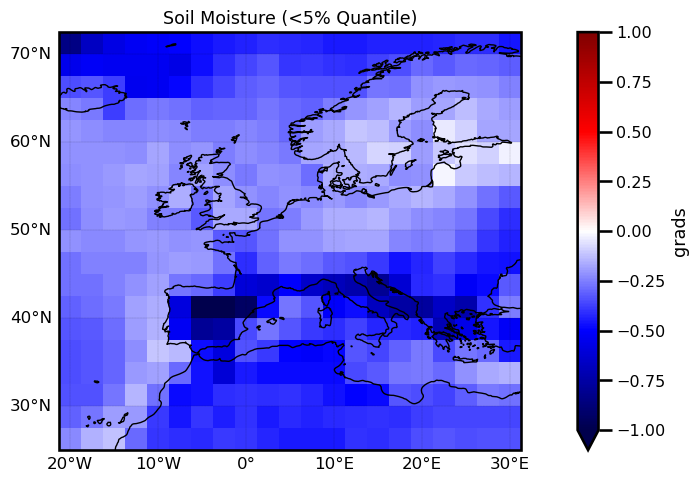

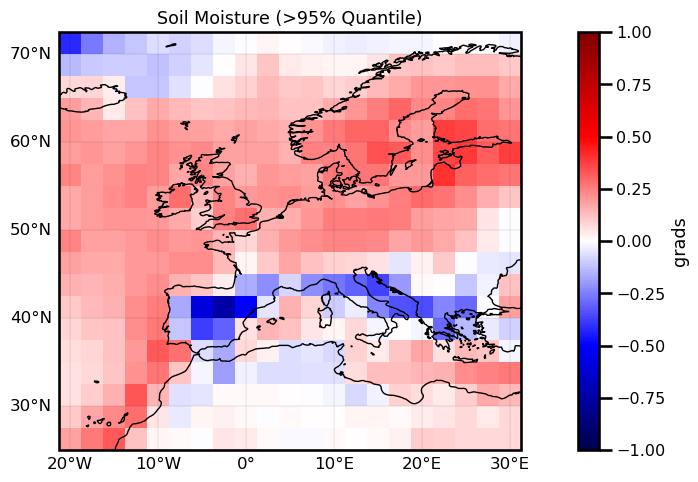

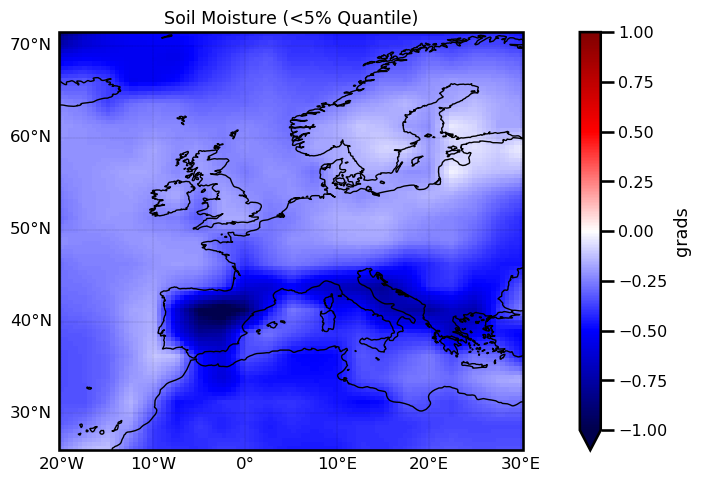

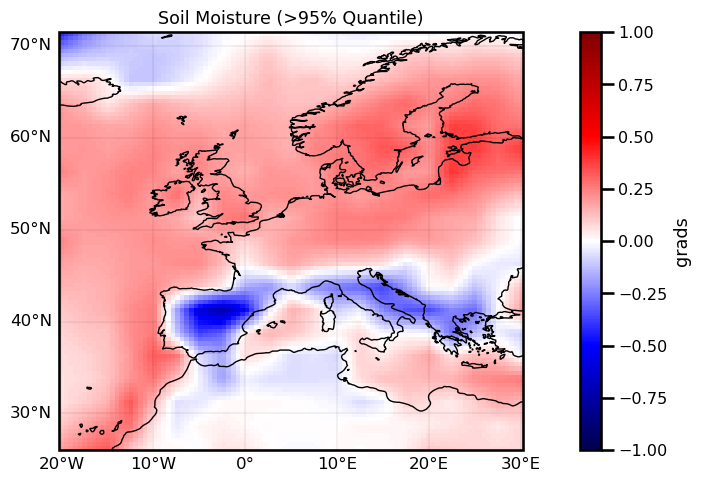

In [57]:
with xr.open_dataset(Path(results_save_dir).joinpath("bhm_mcmc_norm.nc"), group="predictions") as ds:
    
    # extract subsample
    ds = az.extract(ds, num_samples=10_000)

    # select the variable in dataset
    ds = ds.grads

    # select the covariate
    ds = ds.sel(covariate=covariate)

    # calculate the lower quantile
    ds = ds.quantile(q=[0.05, 0.95], dim=["sample", "model"])

    
    plot_pcolormesh(
        ds.sel(quantile=0.05), 
        variable=f"{variable_name} (<5% Quantile)",  
        vmin=-1.0, vmax=1.0, cmap="seismic"
    );

    plot_pcolormesh(
        ds.sel(quantile=0.95), 
        variable=f"{variable_name} (>95% Quantile)", 
        vmin=-1.0, vmax=1.0, cmap="seismic"
    );

    # interpolate
    ds = ds.interp(
        lon=np.linspace(ds.lon.values.min(), ds.lon.values.max(), 100),
        lat=np.linspace(ds.lat.values.min(), ds.lat.values.max(), 100),
        method="linear"
    )
        
    plot_pcolormesh(
        ds.sel(quantile=0.05), 
        variable=f"{variable_name} (<5% Quantile)",  
        vmin=-1.0, vmax=1.0, cmap="seismic"
    );

    plot_pcolormesh(
        ds.sel(quantile=0.95), 
        variable=f"{variable_name} (>95% Quantile)",  
        vmin=-1.0, vmax=1.0, cmap="seismic"
    );



    ds.close()